In [30]:
import os
import cv2
import matplotlib.pyplot as plt

In [31]:
CROP_X = slice(142, 513)
CROP_Y = slice(58, 427)

In [32]:
def load_img(filename, crop=True):
    img = cv2.imread(filename)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    if crop:
        img = img[CROP_Y, CROP_X]
    return img

In [33]:
def list_dir(paths, filter_callback=None):
    filenames = []
    for path in paths:
        for filename in os.listdir(path):
            if filter_callback is None or (callable(filter_callback) and filter_callback(filename)):
                filenames.append(os.path.join(path, filename))
    return filenames

In [92]:
dir_paths = [
    r"../results/cross_entropy_25.05.2021_17.26/test_images/",
    r"../results/cross_entropy_25.05.2021_21.33/test_images/",
    r"../results/cross_entropy_26.05.2021_02.13/test_images/",
    r"../results/focal_25.05.2021_07.27/test_images/",
    r"../results/soft_dice_13.05.2021_20.20/test_images/",
    r"../results/tversky_12.05.2021_23.43/test_images/",
    r"../results/combined_loss_13.05.2021_14.05/test_images/",
]
loss_labels = ["Cross Entropy", "WCE", "BCE", "Focal", "Soft-Dice", "Tversky", "CE + SD"]

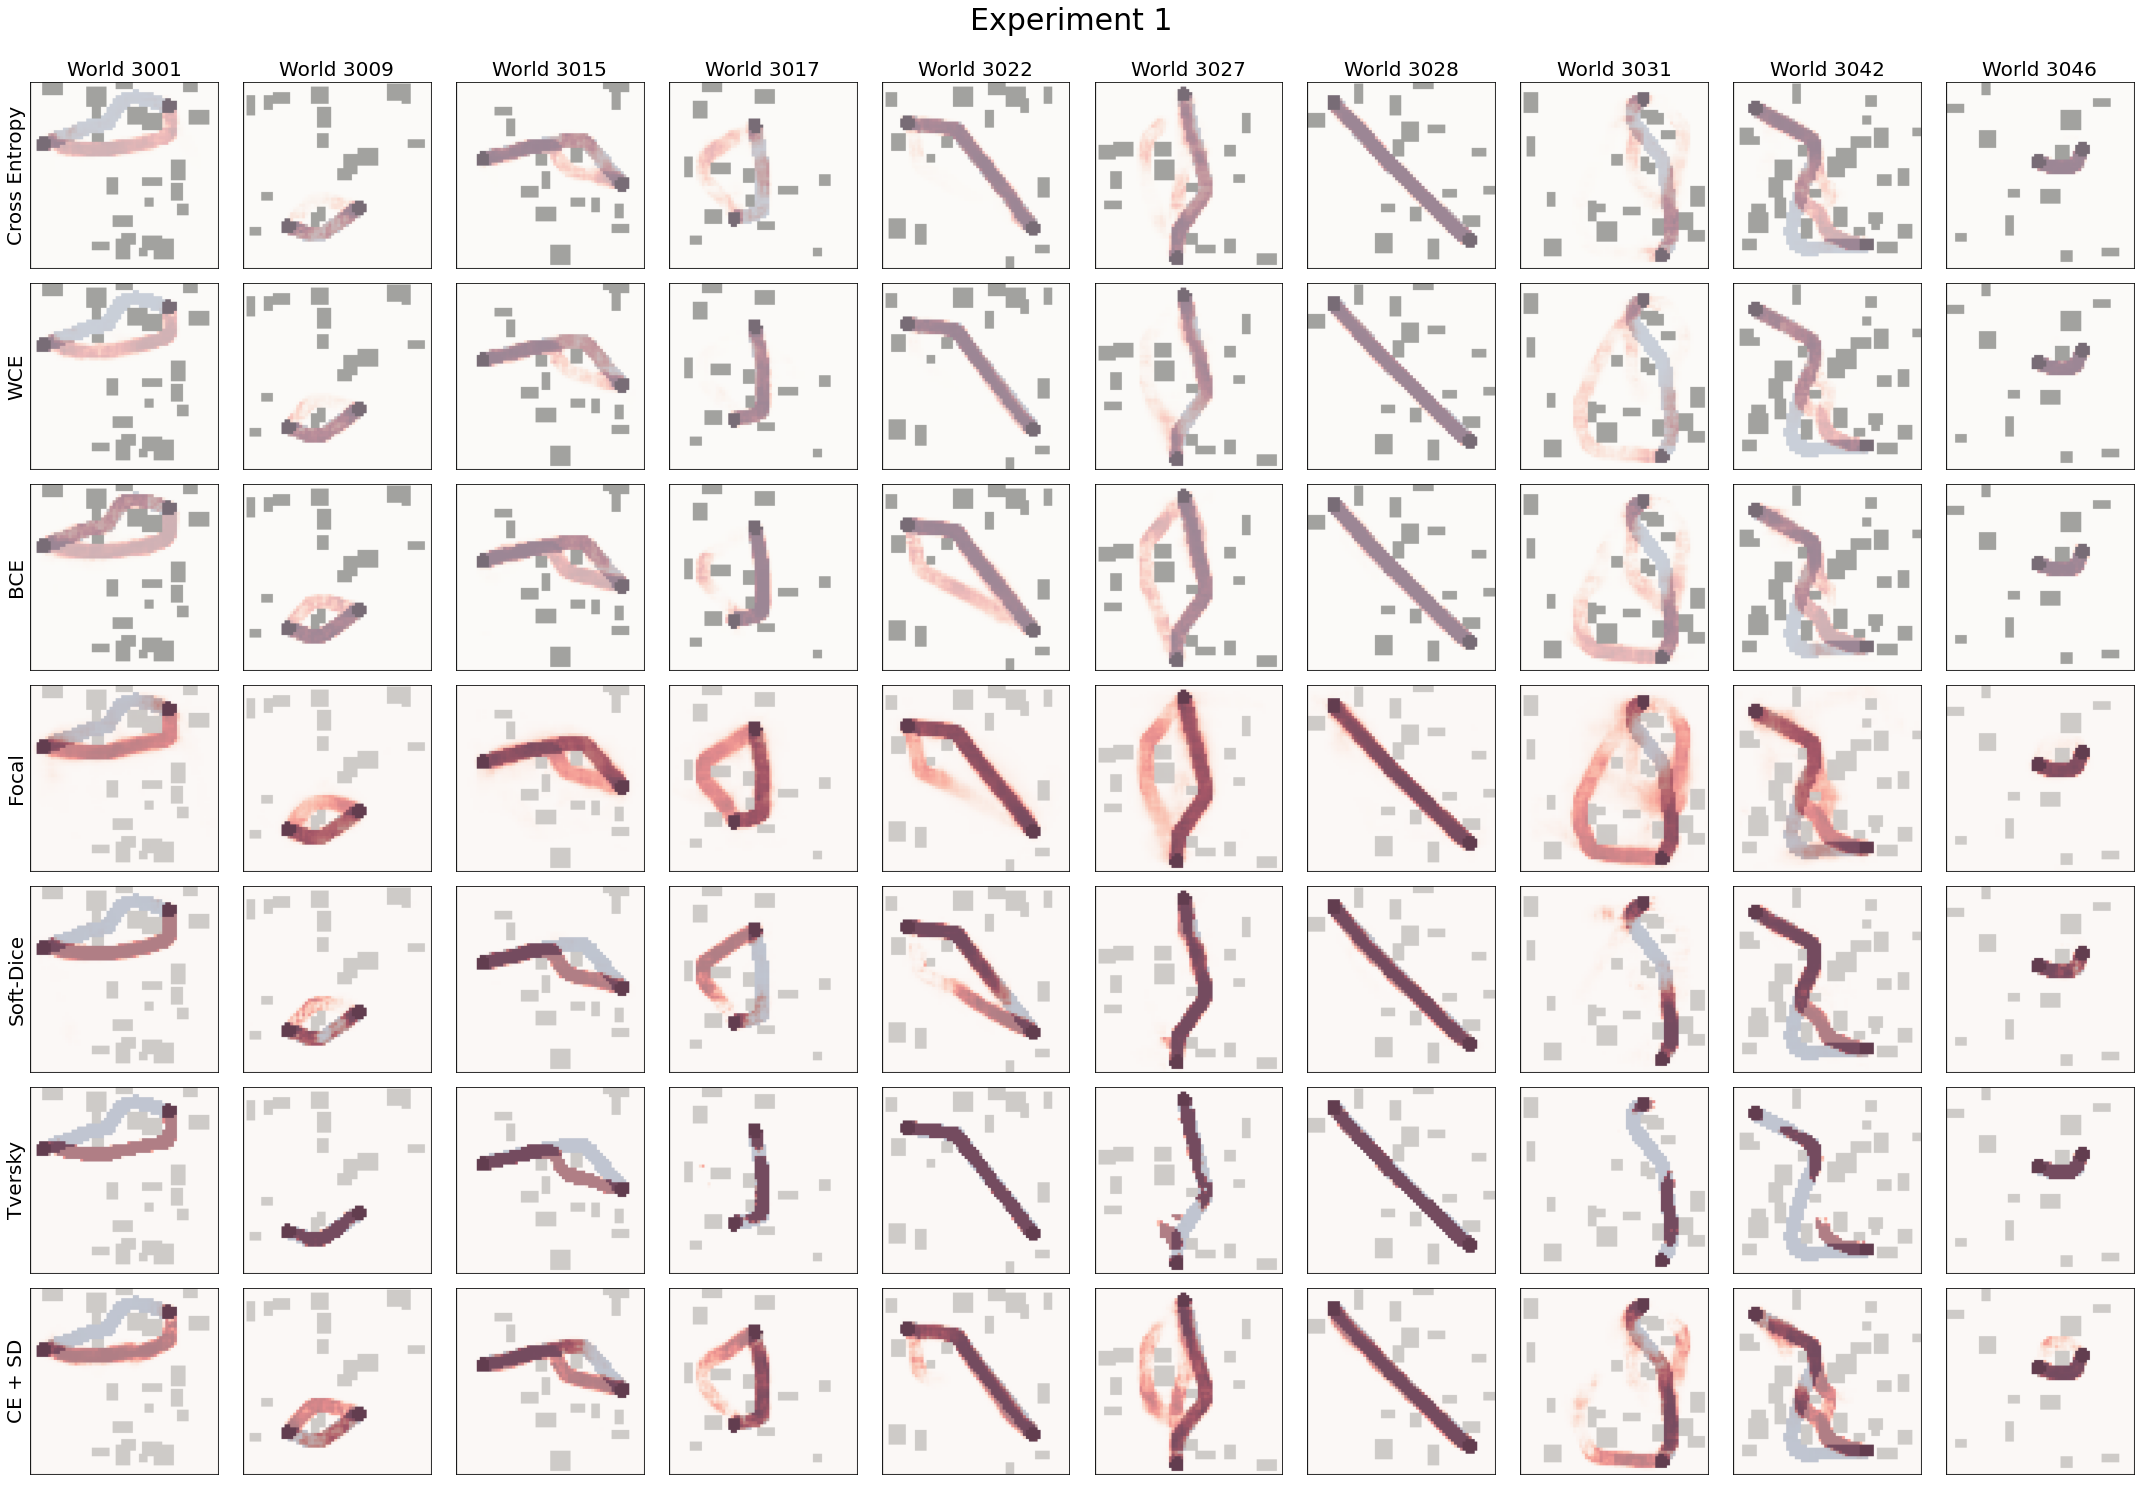

In [96]:
plot_title = "Experiment 1\n"
file_indexes = [7, 38, 169, 113, 184, 70, 111, 125, 63, 89]
file_indexes = sorted(file_indexes)
all_files = [[os.path.join(path, f"Image_{i}.png") for i in file_indexes] for path in dir_paths]
fontsize = 20
nrows = len(all_files)
ncols = len(all_files[0])
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(3*ncols, 3*nrows))
fig.suptitle(plot_title, fontsize=fontsize+10)
for i in range(nrows):
    for j in range(ncols):
        img = load_img(all_files[i][j])
        axs[i, j].imshow(img)
        # Set titles and remove x/y ticks
        if i == 0:
            # TODO: Change the world index formula later
            axs[i, j].set_title(f"World {3000+file_indexes[j]//4}", fontsize=fontsize)
        if j == 0:
            axs[i, j].set_ylabel(loss_labels[i], fontsize=fontsize)
        axs[i, j].set_xticks([])
        axs[i, j].set_yticks([])
fig.tight_layout()
plt.show()

In [2]:
import numpy as np
import tensorflow.compat.v1 as tf

In [39]:
%cd ..
import train_image2image_model as md
%cd notebook

/home/rajk/DIT/ADLR/tum-adlr-ss21-11
/home/rajk/DIT/ADLR/tum-adlr-ss21-11/notebook


In [19]:
db_path = "SingleSphere02.db"
obst_imgs, *_ = md.load_data_from_sql(db_path, table="worlds", cmp_names=["obst_img_cmp"])

In [18]:
cmp_names = ["start_img_cmp", "end_img_cmp", "path_img_cmp"]
path_rows = np.arange(3000000, 3100000, 250)
start_imgs, end_imgs, path_imgs = md.load_data_from_sql(db_path, table="paths", rows=path_rows, cmp_names=cmp_names)
# Numpy.add reduces the memory spike during addition operation compared to the + operator
goal_imgs = np.add(start_imgs, end_imgs, out=start_imgs)
data_dict = {
    "path_rows": path_rows,
    "obst_imgs": obst_imgs,
    "path_imgs": path_imgs,
    "goal_imgs": goal_imgs,
}

In [83]:
data_gen = md.DataGen(data_dict, callback=md.image2image_callback, batch_size=128, length_key="path_rows")

In [27]:
tf.keras.backend.clear_session()
denseNet = tf.keras.models.load_model(r"results/focal_25.05.2021_07.27/model.tf/", compile=False)

In [84]:
log_path = "../temp"
img_dump_path = os.path.join(log_path, "test_images")
os.makedirs(img_dump_path, exist_ok=True)

In [85]:
test_callbacks = [md.ImageSaverCallback(data_gen, img_dump_path, callback=image2image_saver)]
_ = denseNet.predict(data_gen, callbacks=test_callbacks)

Saving 400 images: ████████████████░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░ 32.00% | mean time per iter: 4.54 s | time left: 20:34 |  WARNING:tensorflow:Method (on_predict_batch_end) is slow compared to the batch update (4.406266). Check your callbacks.
Saving 400 images: ████████████████████████████████░░░░░░░░░░░░░░░░░░ 64.00% | mean time per iter: 4.30 s | time left: 10:20 |  WARNING:tensorflow:Method (on_predict_batch_end) is slow compared to the batch update (4.190974). Check your callbacks.
Saving 400 images: ████████████████████████████████████████████████░░ 96.00% | mean time per iter: 4.24 s | time left: 01:08 |  WARNING:tensorflow:Method (on_predict_batch_end) is slow compared to the batch update (4.014354). Check your callbacks.
Saving 400 images: ██████████████████████████████████████████████████ 100.00% | mean time per iter: 3.30 s | time left: 00:00 |  


In [88]:
_.shape

(400, 64, 64, 1)